## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Models / training
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    roc_curve, classification_report, confusion_matrix
)

# Many dependencies have weird warnings/loggings; we disable those since the output
# explodes when put in loops
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("All imports successful!")

All imports successful!


## Supervised Techniques for Predicting Anomalies

### Defining Models
Our evaluation techniques include testing a number of models and a range of different anomaly labeling methods. Therefore, we need to programatically define the models of interest. We create a model dictionary here that both (1) defines our hyperparameters (manually tuned) and the colloquial name that they can be referred to in our evaluation steps.

In [2]:
# Model dictionary with exact hyperparameters from step2.ipynb
model_dict = {
    "Linear Classifier (Logistic Regression)": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Linear SVM": SVC(kernel="linear", class_weight='balanced', probability=True),
    "RBF SVM": SVC(kernel='rbf', class_weight='balanced', probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
}

print(f"Configured {len(model_dict)} models")

Configured 8 models


### Data Management

We will first load and filter our data. Most importantly, we will filter out our models that (as described previously) had no labeled anomalies. There is a subset of the devices that reported very little variation in their models, and some of our labeling methods are not sensitive enough to catch these metrics. We drop these so that our predictive models cannot achieve positive metrics by always guessing one output.

In [16]:
# Load data from save
clean_data = pd.read_csv("clean_labeled.csv")

In [17]:
# Filter to hosts that have at least one anomaly in ANY detection method
# This is necessary because some detection methods are not sensitive enough to pick up on anomalies
# for devices with less variance in their metrics
hosts_with_basic_anomaly = clean_data[clean_data['basic_ema_anomaly'] == True]['hostname'].unique()
hosts_with_dspot_anomaly = clean_data[clean_data['dspot_anomaly'] == True]['hostname'].unique()
hosts_with_tuned_dspot_anomaly = clean_data[clean_data['tuned_dspot_anomaly'] == True]['hostname'].unique()

# Union of all hosts with anomalies
hosts_with_any_anomaly = set(hosts_with_basic_anomaly) | set(hosts_with_dspot_anomaly) | set(hosts_with_tuned_dspot_anomaly)

print(f"Hosts with basic_ema_anomaly: {len(hosts_with_basic_anomaly)}")
print(f"Hosts with dspot_anomaly: {len(hosts_with_dspot_anomaly)}")
print(f"Hosts with tuned_dspot_anomaly: {len(hosts_with_tuned_dspot_anomaly)}")
print(f"Total hosts with ANY anomaly: {len(hosts_with_any_anomaly)}")

# Filter dataframe to only these hosts
df = clean_data[clean_data['hostname'].isin(hosts_with_any_anomaly)].copy()
print(f"\nFiltered to {len(df)} rows from {len(hosts_with_any_anomaly)} hosts")

Hosts with basic_ema_anomaly: 38
Hosts with dspot_anomaly: 24
Hosts with tuned_dspot_anomaly: 32
Total hosts with ANY anomaly: 38

Filtered to 28394 rows from 38 hosts


### Train/Test Split
Although training and testing is normally a naive task, we had to be more careful with our implementation. Since we are backtesting on a feature set that depends on other cells, we must be careful that our model doesn't merely memorize the dataset. We considered a range of solutions, such as partitioning the dataset into a number of smaller, 10-row windows and assigning some proportion to be train vs. test points. However, this would lead to some training points being collected after some testing points. However, we intend for our model to inform real world deployments where the training data is collected before model deployment. Therefore, we decided to split our dataset (which was collected over 3 collection periods) so that the first two collection periods are training data and the last is our training set.

In [5]:
# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"])

# Split into train and test
start_a = pd.Timestamp("2025-04-16")
end_a   = pd.Timestamp("2025-06-20")

start_b = pd.Timestamp("2025-07-01")
end_b   = pd.Timestamp("2025-08-01")

mask_a = (df["date"] >= start_a) & (df["date"] <= end_a)
mask_b = (df["date"] >= start_b) & (df["date"] <= end_b)

train = df[mask_a].copy()
test = df[mask_b].copy()

print(f"Train set: {len(train)} rows")
print(f"Test set: {len(test)} rows")

Train set: 16068 rows
Test set: 12326 rows


### Feature Engineering

We believe that a sliding window approach for feature engineering would offer both crucial predictive information while maintaining technical feasibility. When these models are deployed at scale, it would be hard to maintain a large amount of historical data. Instead, it would be best to score metrics such as the number of anomalies that were seen in the last $n$ recorded measurements. Therefore, each anomaly is defined by every point collected (by the same device) in the last 30 hours. These metrics would be easy to store in Redis, especially as we consider aggregate statistics such as "anomaly_count" that are represented as single integers.

In [6]:
def create_lookback_features(lookback_df, label_col='predictions', latency_to_use='ping_latency'):
    """
    Create lookback features for a window of data.
    
    Args:
        lookback_df: DataFrame with historical data
        label_col: Column name to use as labels (e.g., 'basic_ema_anomaly', 'dspot_anomaly')
        latency_to_use: Column name for latency values
    """
    lookback_df = lookback_df.reset_index(drop=True)

    has_anomalies = lookback_df[label_col].any()
    has_normal = (~lookback_df[label_col]).any()
    
    lookback_features = {
        'anomaly_count': lookback_df[label_col].sum(),
        'anomaly_rate': lookback_df[label_col].mean(),
        'recent_anomaly_count': lookback_df[label_col].tail(3).sum(),
        'datapoints_since_anomaly': ((len(lookback_df) - 1 - lookback_df[lookback_df[label_col] == True].index[-1]) if has_anomalies else -1),
        'has_anomaly_history': float(has_anomalies),
        'latency_during_anomalies': (lookback_df[lookback_df[label_col] == True][latency_to_use].mean() if has_anomalies else -1),
        'latency_during_normal': (lookback_df[lookback_df[label_col] == False][latency_to_use].mean() if has_normal else -1),
        'recent_latency_mean': lookback_df[latency_to_use].tail(3).mean(),
        'baseline_latency_mean': lookback_df[latency_to_use].head(5).mean(),
        'recent_vs_baseline': (lookback_df[latency_to_use].tail(3).mean() / lookback_df[latency_to_use].head(5).mean() if lookback_df[latency_to_use].head(5).mean() > 0 else 1.0),
        'recent_latency_max': lookback_df[latency_to_use].tail(3).max(),
        'latency_trend': (lookback_df[latency_to_use].iloc[-1] - lookback_df[latency_to_use].iloc[0]) / len(lookback_df),
        'anomaly_clustering': lookback_df[label_col].rolling(3).sum().max() if len(lookback_df) >= 3 else 0,
        'missing_points': lookback_df[latency_to_use].isna().sum(),
        'completeness': 1 - lookback_df[latency_to_use].isna().mean()
    }
    return lookback_features


def get_feature_df(og_df, label_col='predictions', latency_to_use='ping_latency'):
    """
    Create a feature dataframe with lookback windows.
    
    Args:
        og_df: Original dataframe sorted by date
        label_col: Column name to use as labels
        latency_to_use: Column name for latency values
    """
    initial = create_lookback_features(og_df.iloc[0:10], label_col=label_col, latency_to_use=latency_to_use)
    featured_df = pd.DataFrame(columns=list(initial.keys()) + ['label', 'date', 'hostname'])
    TOL = pd.Timedelta(minutes=2)

    for i, row in og_df.iloc[9:].iterrows():
        end_time = og_df.loc[i, 'date']
        start_time = end_time - pd.Timedelta(hours=30)
        lookback_df = og_df[(og_df['date'] >= start_time + TOL) & (og_df['date'] < end_time - TOL)].copy()
        if len(lookback_df) == 0:
            continue
        lookback_features = create_lookback_features(lookback_df, label_col=label_col, latency_to_use=latency_to_use)
        label = og_df.loc[i, label_col]
        hostname = og_df.loc[i, 'hostname']
        row = {**lookback_features, 'label': label, 'date': end_time, 'hostname': hostname}
        featured_df.loc[len(featured_df)] = row

    return featured_df


def transform_single_df_to_features(df, cur_hostname, label_col='predictions'):
    """
    Transform a single device's data to features.
    
    Args:
        df: Full dataframe
        cur_hostname: Hostname to filter by
        label_col: Column name to use as labels
    """
    host_isolated = df[df['hostname'] == cur_hostname]
    host_isolated = host_isolated.sort_values(by='date', ascending=True)
    return get_feature_df(host_isolated, label_col=label_col, latency_to_use='ping_latency')


print("Feature engineering functions defined")

Feature engineering functions defined


### Evaluation Metrics

Finally, we had to consider the metrics on which we should actually evaluate our models. Of course, anomalies represent a very small amount of the data (around $3%$ with the tuned (D)SPOT method), so models can achieve very high accuracy by never predicting anomalies. Instead, we considered two metrics:
- **FPR at 90% Recall**: What false positive rate is needed to catch 90% of anomalies
- **Recall at 10% FPR**: What percentage of anomalies are caught with 10% false positive rate

The first is designed to represent the efficiency for high-uptime clients. If they want to predict 90% of anomalies, how many false positives will they receive? The second is meant to represent low-resource clients. Addressing network degredation requires engineering hours, so false positives can be expensive. The second customer would be interested in how many anomalies they could catch while only allowing a 10% false positive rate.

In [18]:
def calculate_threshold_metrics(y_test, y_proba):
    """
    Calculate threshold-based metrics using ROC curve.
    """
    # Handle edge case
    if y_test.sum() == 0:
        return -1, -1
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    # FPR at 90% Recall (TPR)
    idx_90_recall = np.where(tpr >= 0.90)[0]
    fpr_at_90_recall = fpr[idx_90_recall[0]] if len(idx_90_recall) > 0 else 1.0
    
    # Recall at 10% FPR
    idx_10_fpr = np.where(fpr <= 0.10)[0]
    recall_at_10_fpr = tpr[idx_10_fpr[-1]] if len(idx_10_fpr) > 0 else 0.0
    
    return fpr_at_90_recall, recall_at_10_fpr


def evaluate_model_per_device(X_train, y_train, X_test, y_test, hostname):
    """
    Train all models and evaluate on test set for a single device.
    
    Args:
        X_train, y_train: Training features and labels
        X_test, y_test: Test features and labels
        hostname: Device hostname
    
    Returns:
        List of result dictionaries for each model
    """
    results = []

    for model_name, clf in model_dict.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        try:
            y_proba = clf.predict_proba(X_test)[:, 1]
            has_proba = True
        except:
            y_proba = None
            has_proba = False
        
        # Standard metrics
        accuracy = clf.score(X_test, y_test)
        f1_anomaly = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
        precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        roc_auc = -1
        fpr_at_90_recall = -1
        recall_at_10_fpr = -1
        
        if has_proba:
            roc_auc = roc_auc_score(y_test, y_proba)
            fpr_at_90_recall, recall_at_10_fpr = calculate_threshold_metrics(y_test, y_proba)

        results.append({
            'model': model_name,
            'hostname': hostname,
            'accuracy': accuracy,
            'f1_score': f1_anomaly,
            'precision': precision,
            'recall': recall,
            'roc_auc': roc_auc,
            'fpr_at_90_recall': fpr_at_90_recall,
            'recall_at_10_fpr': recall_at_10_fpr,
            'true_positives': tp,
            'false_positives': fp,
            'true_negatives': tn,
            'false_negatives': fn,
            'caught_anomalies': tp,
            'missed_anomalies': fn,
            'false_alarms': fp,
            'total_test_samples': len(y_test),
            'total_anomalies': y_test.sum()
        })

    return results


print("Model evaluation functions defined")

Model evaluation functions defined


### Execution

Now, we can loop over all of our models and evaluate their performance on each of the three labeling techniques.

In [19]:
# Define the three anomaly columns to evaluate
anomaly_columns = ['basic_ema_anomaly', 'dspot_anomaly', 'tuned_dspot_anomaly']

# Store results for each method
all_results_by_method = {}

# Columns to remove when creating features
remove_cols = ['label', 'date', 'hostname']

print("="*80)
print("EVALUATING PER-DEVICE MODELS FOR EACH ANOMALY DETECTION METHOD")
print("="*80)

for label_col in anomaly_columns:
    print(f"\n{'='*80}")
    print(f"ANOMALY DETECTION METHOD: {label_col}")
    print(f"{'='*80}\n")
    
    # Filter to hosts that have anomalies in both train and test for this method
    train_hostnames_with_anomalies = train[train[label_col] == True]['hostname'].unique()
    test_hostnames_with_anomalies = test[test[label_col] == True]['hostname'].unique()
    hostnames_in_both = set(train_hostnames_with_anomalies).intersection(set(test_hostnames_with_anomalies))
    
    print(f"Hosts with anomalies in train: {len(train_hostnames_with_anomalies)}")
    print(f"Hosts with anomalies in test: {len(test_hostnames_with_anomalies)}")
    print(f"Hosts with anomalies in BOTH train and test: {len(hostnames_in_both)}\n")
    
    if len(hostnames_in_both) == 0:
        print(f"WARNING: No hosts have anomalies in both train and test for {label_col}. Skipping.\n")
        continue
    
    # Filter train and test to only these hosts
    train_filtered = train[train['hostname'].isin(hostnames_in_both)]
    test_filtered = test[test['hostname'].isin(hostnames_in_both)]
    
    # Evaluate models for each host
    method_results = []
    
    for i, cur_hostname in enumerate(hostnames_in_both, 1):
        print(f"[{i}/{len(hostnames_in_both)}] Host: {cur_hostname}")
        
        # Create features using this label column
        train_single_w_lookback = transform_single_df_to_features(train_filtered, cur_hostname, label_col=label_col)
        test_single_w_lookback = transform_single_df_to_features(test_filtered, cur_hostname, label_col=label_col)
        
        # Prepare X and y
        X_train = train_single_w_lookback.drop(columns=remove_cols)
        X_test = test_single_w_lookback.drop(columns=remove_cols)
        y_train = train_single_w_lookback["label"].astype(int)
        y_test = test_single_w_lookback["label"].astype(int)
        
        # Evaluate models
        hostname_results = evaluate_model_per_device(X_train, y_train, X_test, y_test, cur_hostname)
        
        method_results.extend(hostname_results)
    
    # Store results for this method
    all_results_by_method[label_col] = pd.DataFrame(method_results)

    print(f"\nCompleted {label_col}\n")
    print("="*80)

print("EVALUATION COMPLETE")
print("\n" + "="*80)

EVALUATING PER-DEVICE MODELS FOR EACH ANOMALY DETECTION METHOD

ANOMALY DETECTION METHOD: basic_ema_anomaly

Hosts with anomalies in train: 37
Hosts with anomalies in test: 35
Hosts with anomalies in BOTH train and test: 34

[1/34] Host: d493afd
[2/34] Host: 6ca8355
[3/34] Host: 9840de6
[4/34] Host: 575f518
[5/34] Host: b340432
[6/34] Host: b2c53ee
[7/34] Host: b407ebe
[8/34] Host: dede9dc
[9/34] Host: b5c8445
[10/34] Host: 33fe84e
[11/34] Host: 592a43c
[12/34] Host: 64b750b
[13/34] Host: 2620a05
[14/34] Host: 24a22bf
[15/34] Host: a2e0486
[16/34] Host: 7f6d63d
[17/34] Host: 8445893
[18/34] Host: 9dc32f2
[19/34] Host: 0f42441
[20/34] Host: f8f4b44
[21/34] Host: c073f39
[22/34] Host: da6d469
[23/34] Host: ed86ea2
[24/34] Host: 5bf17fc
[25/34] Host: 1a21874
[26/34] Host: 9ab8252
[27/34] Host: 953d46d
[28/34] Host: 38b6bf0
[29/34] Host: 972f622
[30/34] Host: 63598f8
[31/34] Host: 43e847f
[32/34] Host: 5c5004f
[33/34] Host: 25b3303
[34/34] Host: 29129b6

Completed basic_ema_anomaly


ANOMA

### Output Statistics

Now that we've executed our models, we wanted to see how different models compare on average. Each of our models was trained per device, so we average their metrics and report them for every labeling technique.

In [20]:
print("\n" + "="*80)
print("AGGREGATE RESULTS BY ANOMALY DETECTION METHOD")
print("="*80 + "\n")

for label_col, results_df in all_results_by_method.items():
    print(f"\n{'='*80}")
    print(f"METHOD: {label_col}")
    print(f"{'='*80}\n")
    
    # Group by model and calculate mean metrics
    grouped = results_df.groupby('model').agg({
        'accuracy': 'mean',
        'fpr_at_90_recall': 'mean',
        'recall_at_10_fpr': 'mean',
    }).round(4)
    
    print("Key Metrics (averaged across devices):")
    print(grouped.to_string())
    
    print("\n" + "-"*80)
    print("Best Models:")
    print("-"*80)
    best_acc = grouped['accuracy'].idxmax()
    best_fpr_90 = grouped['fpr_at_90_recall'].idxmin()  # Lower is better
    best_recall_10 = grouped['recall_at_10_fpr'].idxmax()  # Higher is better
    
    print(f"Best Accuracy: {best_acc} ({grouped.loc[best_acc, 'accuracy']:.4f})")
    print(f"Best FPR at 90% Recall: {best_fpr_90} ({grouped.loc[best_fpr_90, 'fpr_at_90_recall']:.4f})")
    print(f"Best Recall at 10% FPR: {best_recall_10} ({grouped.loc[best_recall_10, 'recall_at_10_fpr']:.4f})")
    
    print("\n")


AGGREGATE RESULTS BY ANOMALY DETECTION METHOD


METHOD: basic_ema_anomaly

Key Metrics (averaged across devices):
                                         accuracy  fpr_at_90_recall  recall_at_10_fpr
model                                                                                
AdaBoost                                   0.8345            0.8752            0.1315
Decision Tree                              0.6737            0.9958            0.0357
Linear Classifier (Logistic Regression)    0.6529            0.7983            0.1566
Linear SVM                                 0.6037            0.8291            0.1513
Naive Bayes                                0.7543            0.8654            0.2127
Nearest Neighbors                          0.8400            1.0000            0.0965
RBF SVM                                    0.5632            0.8424            0.1689
Random Forest                              0.8681            0.8589            0.1588

------------------------

### Cross-Device Predictive Model

Training one model per device inherently increases a system's compute overhead. Therefore, it would be helpful if one model was capable of detecting anomalies across a range of devices, since it could be trained once and deployed in multiple contexts.

#### Multi-Device Feature Engineering

Our feature engineering helpers are defined to operate over one host at once, so we need an additional helper to combine that output into a single dataframe.

In [21]:
def transform_multidevice_df_to_features(df, label_col='predictions'):
    """
    Create features for all devices combined.
    
    Args:
        df: Full dataframe with multiple devices
        label_col: Column name to use as labels
    """
    hostnames = df["hostname"].unique().tolist()
    featured_dfs = []
    
    for cur_hostname in hostnames:
        host_isolated = df[df['hostname'] == cur_hostname]
        host_isolated = host_isolated.sort_values(by='date', ascending=True)
        feature_df = get_feature_df(host_isolated, label_col=label_col, latency_to_use='ping_latency')
        featured_dfs.append(feature_df)
    
    final_df = pd.concat(featured_dfs, ignore_index=True)
    return final_df

print("Multi-device feature engineering function defined")

Multi-device feature engineering function defined


#### Evaluate Multi-Device Models

As we evaluate these models, we also need to consider normalization. Each device is positioned differently within the network, so they report different latencies. Therefore, we need to normalize the mean and variance for each of the datasets so that the multi-device model can learn general trends.

In [22]:
# Store multi-device results
all_multidevice_results = {}

print("="*80)
print("EVALUATING MULTI-DEVICE MODELS (TRAINED ON ALL DATA COMBINED)")
print("="*80)

for label_col in anomaly_columns:
    print(f"\n{'='*80}")
    print(f"MULTI-DEVICE MODEL FOR: {label_col}")
    print(f"{'='*80}\n")
    
    # Use the same filtered train/test as per-device models
    # Get hosts with anomalies in both train and test
    train_hostnames_with_anomalies = train[train[label_col] == True]['hostname'].unique()
    test_hostnames_with_anomalies = test[test[label_col] == True]['hostname'].unique()
    hostnames_in_both = set(train_hostnames_with_anomalies).intersection(set(test_hostnames_with_anomalies))
    
    if len(hostnames_in_both) == 0:
        print(f"WARNING: No hosts have anomalies in both train and test for {label_col}. Skipping.\n")
        continue
    
    # Filter to hosts with anomalies in both
    train_filtered = train[train['hostname'].isin(hostnames_in_both)]
    test_filtered = test[test['hostname'].isin(hostnames_in_both)]
    
    # Create features for ALL devices combined
    train_multi_w_lookback = transform_multidevice_df_to_features(train_filtered, label_col=label_col)
    test_multi_w_lookback = transform_multidevice_df_to_features(test_filtered, label_col=label_col)
    
    # Prepare X and y
    X_train = train_multi_w_lookback.drop(columns=remove_cols)
    X_test = test_multi_w_lookback.drop(columns=remove_cols)
    y_train = train_multi_w_lookback["label"].astype(int)
    y_test = test_multi_w_lookback["label"].astype(int)
    
    # Normalize features based on training data only (no leakage)
    train_mean = X_train.mean()
    train_std = X_train.std()
    X_train_normalized = (X_train - train_mean) / train_std
    X_test_normalized = (X_test - train_mean) / train_std  # Use train stats
    
    # Fill NaNs with 0 (from division by zero std)
    X_train_normalized = X_train_normalized.fillna(0)
    X_test_normalized = X_test_normalized.fillna(0)
    
    print(f"Train: {len(X_train)} samples, {y_train.sum()} anomalies ({y_train.mean()*100:.1f}%)")
    print(f"Test: {len(X_test)} samples, {y_test.sum()} anomalies ({y_test.mean()*100:.1f}%)")
    
    # Train and evaluate models
    results = []
    
    for model_name, clf in model_dict.items():
        clf.fit(X_train_normalized, y_train)
        y_pred = clf.predict(X_test_normalized)
        
        try:
            y_proba = clf.predict_proba(X_test_normalized)[:, 1]
            has_proba = True
        except:
            y_proba = None
            has_proba = False
        
        # Standard metrics
        accuracy = clf.score(X_test_normalized, y_test)
        f1_anomaly = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
        precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        roc_auc = -1
        fpr_at_90_recall = -1
        recall_at_10_fpr = -1
        
        if has_proba:
            roc_auc = roc_auc_score(y_test, y_proba)
            fpr_at_90_recall, recall_at_10_fpr = calculate_threshold_metrics(y_test, y_proba)
        
        results.append({
            'model': model_name,
            'accuracy': accuracy,
            'f1_score': f1_anomaly,
            'precision': precision,
            'recall': recall,
            'roc_auc': roc_auc,
            'fpr_at_90_recall': fpr_at_90_recall,
            'recall_at_10_fpr': recall_at_10_fpr,
            'true_positives': tp,
            'false_positives': fp,
            'true_negatives': tn,
            'false_negatives': fn,
            'caught_anomalies': tp,
            'missed_anomalies': fn,
            'false_alarms': fp,
            'total_test_samples': len(y_test),
            'total_anomalies': y_test.sum()
        })
    
    all_multidevice_results[label_col] = pd.DataFrame(results)
    
    # Print results
    results_df = pd.DataFrame(results)
    print("\nResults:")
    for _, row in results_df.iterrows():
        print(f"  {row['model']:45s} | Acc: {row['accuracy']:.3f} | FPR@90%R: {row['fpr_at_90_recall']:.3f} | R@10%FPR: {row['recall_at_10_fpr']:.3f}")
    print()

print("\n" + "="*80)
print("MULTI-DEVICE EVALUATION COMPLETE")
print("="*80)

EVALUATING MULTI-DEVICE MODELS (TRAINED ON ALL DATA COMBINED)

MULTI-DEVICE MODEL FOR: basic_ema_anomaly

Train: 14548 samples, 1769 anomalies (12.2%)
Test: 11071 samples, 1455 anomalies (13.1%)

Results:
  Linear Classifier (Logistic Regression)       | Acc: 0.534 | FPR@90%R: 0.689 | R@10%FPR: 0.293
  Nearest Neighbors                             | Acc: 0.838 | FPR@90%R: 1.000 | R@10%FPR: 0.101
  Linear SVM                                    | Acc: 0.435 | FPR@90%R: 0.689 | R@10%FPR: 0.217
  RBF SVM                                       | Acc: 0.551 | FPR@90%R: 0.747 | R@10%FPR: 0.188
  Decision Tree                                 | Acc: 0.591 | FPR@90%R: 0.745 | R@10%FPR: 0.175
  Random Forest                                 | Acc: 0.867 | FPR@90%R: 0.723 | R@10%FPR: 0.225
  AdaBoost                                      | Acc: 0.868 | FPR@90%R: 0.720 | R@10%FPR: 0.240
  Naive Bayes                                   | Acc: 0.737 | FPR@90%R: 0.703 | R@10%FPR: 0.277


MULTI-DEVICE MODE

#### Report Multi-Device Model Performance

In [23]:
print("\n" + "="*80)
print("MULTI-DEVICE MODEL RESULTS")
print("="*80 + "\n")

for label_col, results_df in all_multidevice_results.items():
    print(f"\n{'='*80}")
    print(f"METHOD: {label_col} (Multi-Device Model)")
    print(f"{'='*80}\n")
    
    print("Key Metrics:")
    print(results_df[['model', 'accuracy', 'fpr_at_90_recall', 'recall_at_10_fpr']].to_string(index=False))
    
    print("\n" + "-"*80)
    print("Best Models:")
    print("-"*80)
    best_acc_idx = results_df['accuracy'].idxmax()
    best_fpr_90_idx = results_df['fpr_at_90_recall'].idxmin()
    best_recall_10_idx = results_df['recall_at_10_fpr'].idxmax()
    
    print(f"Best Accuracy: {results_df.loc[best_acc_idx, 'model']} ({results_df.loc[best_acc_idx, 'accuracy']:.4f})")
    print(f"Best FPR at 90% Recall: {results_df.loc[best_fpr_90_idx, 'model']} ({results_df.loc[best_fpr_90_idx, 'fpr_at_90_recall']:.4f})")
    print(f"Best Recall at 10% FPR: {results_df.loc[best_recall_10_idx, 'model']} ({results_df.loc[best_recall_10_idx, 'recall_at_10_fpr']:.4f})")
    
    print("\n")


MULTI-DEVICE MODEL RESULTS


METHOD: basic_ema_anomaly (Multi-Device Model)

Key Metrics:
                                  model  accuracy  fpr_at_90_recall  recall_at_10_fpr
Linear Classifier (Logistic Regression)  0.534188          0.689164          0.292784
                      Nearest Neighbors  0.837684          1.000000          0.101031
                             Linear SVM  0.434830          0.689060          0.217182
                                RBF SVM  0.550628          0.747400          0.187629
                          Decision Tree  0.591094          0.745320          0.175258
                          Random Forest  0.867401          0.723274          0.224742
                               AdaBoost  0.867943          0.719738          0.239863
                            Naive Bayes  0.736609          0.702891          0.276976

--------------------------------------------------------------------------------
Best Models:
----------------------------------------

### Comparison: Per-Device vs Multi-Device Models

Compare average performance of per-device models with multi-device models

In [24]:
print("\n" + "="*80)
print("COMPARISON: PER-DEVICE vs MULTI-DEVICE MODELS")
print("="*80 + "\n")

for label_col in anomaly_columns:
    if label_col not in all_results_by_method or label_col not in all_multidevice_results:
        continue
    
    print(f"\n{'='*80}")
    print(f"METHOD: {label_col}")
    print(f"{'='*80}\n")
    
    # Per-device average
    per_device_df = all_results_by_method[label_col]
    per_device_avg = per_device_df.groupby('model').agg({
        'accuracy': 'mean',
        'fpr_at_90_recall': 'mean',
        'recall_at_10_fpr': 'mean'
    }).round(4)
    
    # Multi-device
    multi_device_df = all_multidevice_results[label_col].set_index('model')
    
    # Compare
    comparison = pd.DataFrame({
        'Model': per_device_avg.index,
        'Per-Device Acc': per_device_avg['accuracy'].values,
        'Multi-Device Acc': multi_device_df.loc[per_device_avg.index, 'accuracy'].values,
        'Per-Device FPR@90%R': per_device_avg['fpr_at_90_recall'].values,
        'Multi-Device FPR@90%R': multi_device_df.loc[per_device_avg.index, 'fpr_at_90_recall'].values,
        'Per-Device R@10%FPR': per_device_avg['recall_at_10_fpr'].values,
        'Multi-Device R@10%FPR': multi_device_df.loc[per_device_avg.index, 'recall_at_10_fpr'].values,
    })
    
    print("Accuracy Comparison:")
    print(comparison[['Model', 'Per-Device Acc', 'Multi-Device Acc']].to_string(index=False))
    
    print("\n" + "-"*80)
    print("FPR at 90% Recall Comparison (lower is better):")
    print(comparison[['Model', 'Per-Device FPR@90%R', 'Multi-Device FPR@90%R']].to_string(index=False))
    
    print("\n" + "-"*80)
    print("Recall at 10% FPR Comparison (higher is better):")
    print(comparison[['Model', 'Per-Device R@10%FPR', 'Multi-Device R@10%FPR']].to_string(index=False))
    
    print("\n")


COMPARISON: PER-DEVICE vs MULTI-DEVICE MODELS


METHOD: basic_ema_anomaly

Accuracy Comparison:
                                  Model  Per-Device Acc  Multi-Device Acc
                               AdaBoost          0.8345          0.867943
                          Decision Tree          0.6737          0.591094
Linear Classifier (Logistic Regression)          0.6529          0.534188
                             Linear SVM          0.6037          0.434830
                            Naive Bayes          0.7543          0.736609
                      Nearest Neighbors          0.8400          0.837684
                                RBF SVM          0.5632          0.550628
                          Random Forest          0.8681          0.867401

--------------------------------------------------------------------------------
FPR at 90% Recall Comparison (lower is better):
                                  Model  Per-Device FPR@90%R  Multi-Device FPR@90%R
                       

### Visualizing "Best" Models

After considering the metrics above, we decided that Random Forests best modeled per-device predictions and Naive Bayes best modeled multi-device predictions. We considered these the best models over the tuned (D)SPOT dataset, which we believe best models an eventual production deployment

Devices with >= 15 anomalies in test set: 9 out of 25
Anomaly counts per device: [np.int64(50), np.int64(33), np.int64(28), np.int64(25), np.int64(21), np.int64(17), np.int64(15), np.int64(15), np.int64(15), np.int64(14), np.int64(12), np.int64(12), np.int64(10), np.int64(6), np.int64(6), np.int64(5), np.int64(5), np.int64(4), np.int64(3), np.int64(3), np.int64(3), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


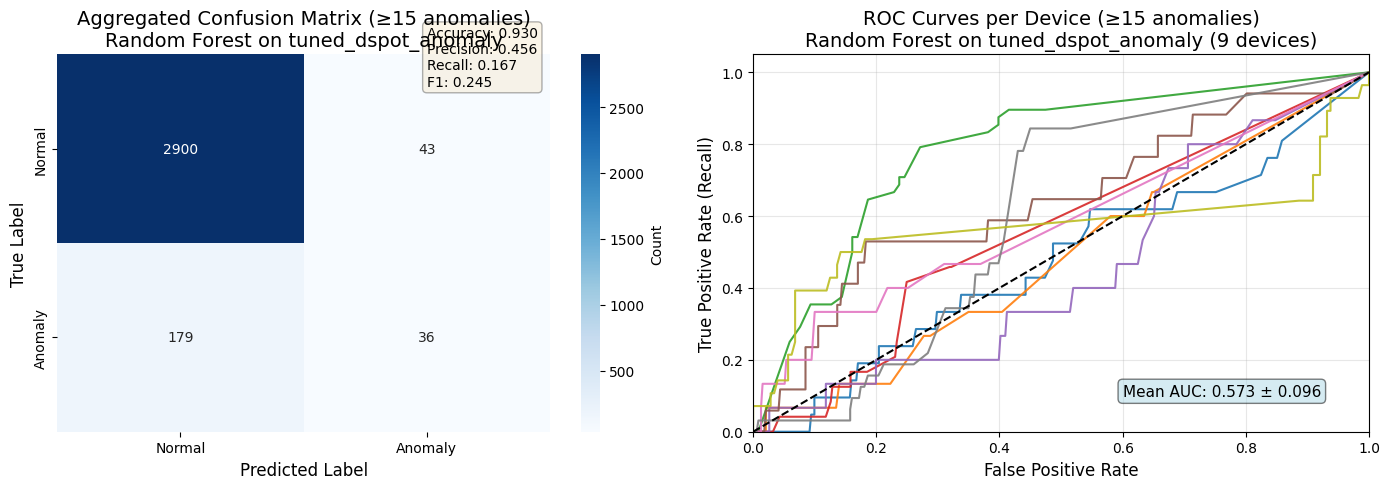


Visualized 9 devices with >= 15 anomalies
Total samples in confusion matrix: 3158
Anomaly rate: 6.81%


In [29]:
# ===================================================================
# CONFIGURABLE THRESHOLD
# ===================================================================
MIN_ANOMALIES = 15  # Minimum number of anomalies required in test set

# ===================================================================
# 1. AGGREGATE CONFUSION MATRIX FOR RANDOM FOREST (TUNED DSPOT)
# ===================================================================

label_col = 'tuned_dspot_anomaly'
model_name = 'Random Forest'

# Get hosts with anomalies in both train and test
train_hostnames_with_anomalies = train[train[label_col] == True]['hostname'].unique()
test_hostnames_with_anomalies = test[test[label_col] == True]['hostname'].unique()
hostnames_in_both = set(train_hostnames_with_anomalies).intersection(set(test_hostnames_with_anomalies))

# Filter to devices with at least MIN_ANOMALIES in test set
test_filtered_initial = test[test['hostname'].isin(hostnames_in_both)]
anomaly_counts = test_filtered_initial[test_filtered_initial[label_col] == True].groupby('hostname').size()
hostnames_with_enough_anomalies = anomaly_counts[anomaly_counts >= MIN_ANOMALIES].index.tolist()

print(f"Devices with >= {MIN_ANOMALIES} anomalies in test set: {len(hostnames_with_enough_anomalies)} out of {len(hostnames_in_both)}")
print(f"Anomaly counts per device: {sorted(anomaly_counts.values, reverse=True)}")

if len(hostnames_with_enough_anomalies) == 0:
    print(f"WARNING: No devices have >= {MIN_ANOMALIES} anomalies. Try lowering MIN_ANOMALIES.")
else:
    train_filtered = train[train['hostname'].isin(hostnames_with_enough_anomalies)]
    test_filtered = test[test['hostname'].isin(hostnames_with_enough_anomalies)]
    
    # Get Random Forest results for devices with enough anomalies
    rf_results = all_results_by_method[label_col]
    rf_results = rf_results[(rf_results['model'] == model_name) & 
                           (rf_results['hostname'].isin(hostnames_with_enough_anomalies))]
    
    # Aggregate confusion matrix across filtered devices
    total_tp = rf_results['true_positives'].sum()
    total_fp = rf_results['false_positives'].sum()
    total_tn = rf_results['true_negatives'].sum()
    total_fn = rf_results['false_negatives'].sum()
    
    # Create confusion matrix
    conf_matrix = np.array([[total_tn, total_fp],
                            [total_fn, total_tp]])
    
    # Plot confusion matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'],
                cbar_kws={'label': 'Count'})
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_title(f'Aggregated Confusion Matrix (≥{MIN_ANOMALIES} anomalies)\n{model_name} on {label_col}', fontsize=14)
    
    # Add summary statistics
    total = conf_matrix.sum()
    accuracy = (total_tp + total_tn) / total
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    stats_text = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1: {f1:.3f}'
    ax1.text(1.5, -0.15, stats_text, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # ===================================================================
    # 2. ROC CURVES (ONE PER DEVICE)
    # ===================================================================
    
    # Get the Random Forest classifier
    clf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
    
    # Store ROC data for each device
    roc_data = []
    
    for cur_hostname in hostnames_with_enough_anomalies:
        # Create features
        train_single_w_lookback = transform_single_df_to_features(train_filtered, cur_hostname, label_col=label_col)
        test_single_w_lookback = transform_single_df_to_features(test_filtered, cur_hostname, label_col=label_col)
        
        # Prepare X and y
        X_train = train_single_w_lookback.drop(columns=remove_cols)
        X_test = test_single_w_lookback.drop(columns=remove_cols)
        y_train = train_single_w_lookback["label"].astype(int)
        y_test = test_single_w_lookback["label"].astype(int)
        
        # Train and predict
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        roc_data.append({
            'hostname': cur_hostname,
            'fpr': fpr,
            'tpr': tpr,
            'auc': roc_auc
        })
    
    # Plot ROC curves
    for data in roc_data:
        ax2.plot(data['fpr'], data['tpr'], alpha=0.9, linewidth=1.5)
    
    # Plot diagonal reference line
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
    
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate (Recall)', fontsize=12)
    ax2.set_title(f'ROC Curves per Device (≥{MIN_ANOMALIES} anomalies)\n{model_name} on {label_col} ({len(roc_data)} devices)', fontsize=14)
    ax2.grid(alpha=0.3)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    # Add AUC statistics
    mean_auc = np.mean([d['auc'] for d in roc_data])
    std_auc = np.std([d['auc'] for d in roc_data])
    auc_text = f'Mean AUC: {mean_auc:.3f} ± {std_auc:.3f}'
    ax2.text(0.6, 0.1, auc_text, fontsize=11,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualized {len(roc_data)} devices with >= {MIN_ANOMALIES} anomalies")
    print(f"Total samples in confusion matrix: {total}")
    print(f"Anomaly rate: {(total_tp + total_fn) / total * 100:.2f}%")